Метод из оригинальной статьи

Balanced difficulty task finder: an adaptive recommendation method for learning tasks based on the concept of state of flow
$$
    \min(0,\max(1,))
$$
https://pubmed.ncbi.nlm.nih.gov/33014180/

Polyak–Ruppert averaging

Полученные коэффицеинты подставляемые в функцию отклика $\theta_k = \frac{1}{k} \sum^{k-1}_j=0 \theta_j$

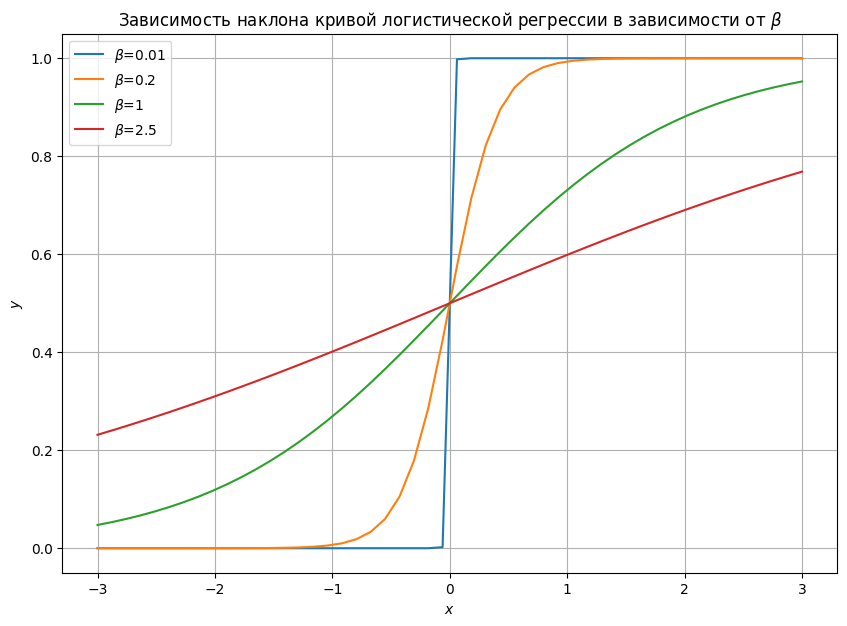

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-3,3)

def logistic(x,alpha =0.2,beta=0.5):
    return 1 / (1 + np.exp(-(x-alpha)/beta))

plt.figure(figsize=(10,7))
for beta in [0.01, 0.2,1,2.5]:
    plt.plot(x, logistic(x,alpha=0,beta=beta),label = r'$\beta$={}'.format(beta))
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.grid()
plt.title(r'Зависимость наклона кривой логистической регрессии в зависимости от $\beta$')
plt.savefig('logistic.png')

In [3]:
from dataclasses import dataclass
from scipy import special
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numpy as np
import typing as tp 
import abc


In [4]:
class AbstractUpdateRule:
    '''
    Марковское правило обновления 
    @player_level:  Уровень игрока float[0,1]
    @dispersion: Ошибка наблюдения float[0,\infty]
    @response_rate: Скорость реакции float[0,\infty]
    '''
    def __init__(self,response_rate: float,optimal_try_rate:float):
        pass
        
    @abc.abstractmethod
    def __call__(self,difficulty: float, result: int):
        pass

    @abc.abstractmethod
    def coefficients_chain(self):
        pass

    def clear(self):
        self.chain = self.coefficients_chain()

    def __call__(self,difficulty: float, result: int):
        an, bn = next(self.chain)
        projection = lambda x : min(max(0,x),1)
        return projection(difficulty +  an* ( result - bn))

class ConstantUpdateRule(AbstractUpdateRule):
    def __init__(self,response_rate: float, optimal_try_rate: float ):
        self.response_rate = response_rate
        self.optimal_try_rate = optimal_try_rate
        self.chain = self.coefficients_chain()

    def coefficients_chain(self):
        self.counter = 0
        while True:
            yield  self.response_rate, self.optimal_try_rate

class RobinsUpdateRule(AbstractUpdateRule):
    def __init__(self,response_rate: float, optimal_try_rate: float ):
        self.response_rate = response_rate
        self.chain =  self.coefficients_chain()
        self.optimal_try_rate = optimal_try_rate

    def coefficients_chain(self):
        self.counter = 0
        while True:
            self.counter += 1 
            yield self.response_rate / self.counter,self.optimal_try_rate

class AdaptedLogisticRule(AbstractUpdateRule):
    def __init__(self, start_point = 0.7, optimal_try_rate: float =0.5, slop: float =1, rounds:int=500,):
        '''
        Use assumption of response as elo model(logistic response)
        and difficulty error distribution as \mathcal{N}
        @optimal: target value
        @start_point: start point of algorithm
        @steps: steps
        '''
        self.optimal = optimal_try_rate
        self.rounds = rounds
        self.start_point = start_point 
        self.slop = slop
        
        self.target_value = special.erfinv(self.optimal) 
        self.response_slop =  self.slop * self.optimal *(1-self.optimal) / stats.norm.pdf(self.target_value)
        self.initial_nu = self.response_slop**2 * (self.target_value - self.start_point)**2        
        self.prepared_coefficients = []
        self.prepare_coefficients()
        self.chain = self.coefficients_chain()

    def prepare_coefficients(self):
        nu = self.initial_nu
        for _ in range(self.rounds):
            b = special.erf(self.target_value /(1+nu)**0.5)
            c = nu / (1+ nu)**0.5  * stats.norm().pdf(self.target_value /(1+nu)**0.5)
            a = c /  self.response_slop / (b *(1-b)) 
            nu = nu - c **2/(b*(1-b))
            self.prepared_coefficients.append((float(a),float(b)))

    def coefficients_chain(self) :
        for (a,b) in self.prepared_coefficients:
            yield a,b



In [71]:
class PolyakModifier:
    '''
    Использование метода Поляка для усреднения последних итераций
    '''
    def __init__(self, update_rule: AbstractUpdateRule,  cut_window: int=5):
        self.storage = []
        self.update_rule = update_rule
        self.cut_window = cut_window

    def __call__(self,difficulty: float, result: int):
        self.storage.append(self.update_rule(difficulty,result))
        if len(self.storage) > self.cut_window:
            return sum(self.storage[-self.cut_window:]) / self.cut_window
        else:
            return sum(self.storage) / len(self.storage)
    
    def clear(self):
        self.storage=[]
        self.update_rule.clear()

In [6]:
class ResponseFunction:
    def __init__(self, response_function: tp.Callable[[float],float]):
        self.response_function = response_function
             
    def __call__(self, difficulty: float):
        return float(self.response_function(difficulty) > random.random())
    
    def plot(self):
        x=np.linspace(-3,3)
        plt.plot(x,self.response_function(x))

In [7]:
from contextlib import contextmanager

class History:
    def __init__(self):
        self.storage = []

    @contextmanager
    def new_log(self):
        new_log = []
        yield new_log
        self.storage.append(new_log)

    @staticmethod
    def bernoulli_quant_estimation(array: np.array,alpha: float):
        p, n = np.mean(array,axis=0), array.shape[1]
        norm_quantile = stats.norm().ppf(1-alpha)
        deviation = norm_quantile * ((p*(1-p))/ n)** 0.5
        return p - deviation, p + deviation

    def confidence_intervals(self,alpha: float=0.05):
        array = np.array(self.storage,dtype=np.float32)
        return (
            (
                np.quantile(array[:,:,0], alpha, axis=0),
                np.quantile(array[:,:,0], 1-alpha, axis=0)
            ),
            self.bernoulli_quant_estimation(array[:,:,1],alpha=alpha),
        )

    @staticmethod
    def running_mean(array: np.array,skip:int = 10,window:int = 20):
        tmp = array.T
        result = np.zeros_like(tmp)
        cumulative_sum  = np.cumsum(tmp,axis=0)
        result[:skip] = np.NaN
        result[skip:window] = cumulative_sum[skip:window] / (np.arange(window)[skip:,np.newaxis]+1)
        result[window:] = (cumulative_sum[window:] - cumulative_sum[:-window]) / window
        return result.T
    
    def sample_trajectories(self,n_samples:int = 10):
        trajectories = np.array(random.sample(self.storage,n_samples),dtype=np.float32)
        return trajectories[:,:,0], self.running_mean(trajectories[:,:,1])

    def mean(self):
        array = np.array(self.storage,dtype=np.float32)
        return np.mean(array[:,:,0],axis=0), np.mean(array[:,:,1],axis=0)

In [8]:
class Test:
    def __init__(self, 
        initial_difficulty: float,
        rounds: int,
        tries:int,
        response_function: ResponseFunction,
        update_rule: AbstractUpdateRule
    ):
        '''
        Инициализирует тест
        @rounds: число раундов проведения тестирования
        @tries: число повтора эксперимента для усреднения
        @init_difficulty: Начальный уровень сложности float[0,1]
 
        '''

        self.response_function = response_function
        self.update_rule = update_rule
        self.initial_difficulty = initial_difficulty
        self.round_number = rounds
        self.tries= tries
        self.history = History()

    def perform(self):
        for _ in tqdm(range(self.tries)):
            self.update_rule.clear()
            difficulty = self.initial_difficulty
            with self.history.new_log() as log:
                log.append([difficulty, np.NaN])
                for __ in range(self.round_number):
                    difficulty, result = self.round(difficulty)
                    log.append([difficulty, result])
        return self

    def round(self, previous_difficulty: int):
        self.result = self.response_function(previous_difficulty)
        self.difficulty = self.update_rule(previous_difficulty,self.result)
        return  self.difficulty,self.result



In [37]:
class Plotter:
    def __init__(self,title: str, 
            min_val = 0.2, max_val = 0.6,
        ):
        '''
        @title: Название эксперимента
        '''
        self.title = title
        fig,ax = plt.subplots(1,2,figsize=(15,5))
        self.fig = fig 
        self.ax = ax
        ax[0].set_ylim(0, 1)
        ax[1].set_ylim(min_val, max_val)
        fig.suptitle(self.title)
    
    def plot_hline(self,optimal):
        self.ax[1].axhline(optimal, linestyle='--', label='Целевое значение')
        return self
        
    def plot_mean(self,history: History,label='Cреднее'):   
        mean_difficulty, mean_efficiency = history.mean()
    
        self.ax[0].plot(mean_difficulty,label=label)
        self.ax[1].plot(mean_efficiency,label=label)
        return self
    
    def confidence_interval(self,history: History, label=r'Доверительный интервал $\alpha=0.05$', color='b'):
        (left_difficulty,right_difficulty), (left_efficiency,right_efficiency) = history.confidence_intervals()
        self.ax[0].fill_between(
            range(len(left_difficulty)),
            left_difficulty,right_difficulty,
            color=color, alpha=.1,
            label=label
        )
        self.ax[1].fill_between(
            range(len(left_difficulty)),
            left_efficiency,
            right_efficiency,
            color=color,alpha=.1,
            label=label
        )
        return self

    def plot_trajectories(self,history: History, n_trajectories= 10):
        def plot_with_label(ax, arr: np.array):
            ax.plot(arr[0],alpha=0.2,color='b', label='Траектории')
            ax.plot(arr[1:].T,alpha=0.2,color='b')

        difficulty_trajectories, efficiency_trajectories = history.sample_trajectories(n_trajectories)

        plot_with_label(self.ax[0],difficulty_trajectories)
        plot_with_label(self.ax[1], efficiency_trajectories)
        return self
    
    def show(self):
        self.ax[0].set(title=r'Уровень сложности $d$')
        self.ax[1].set(title=r'Доля успеха $s$')
        self.ax[0].grid()
        self.ax[1].grid()
        self.ax[0].legend()
        self.ax[1].legend()
        plt.show()

In [10]:
def experiment(
    update_rules: list[AbstractUpdateRule],
    titles: list[str],
    optimal_try_rate:float,
    initial_difficulty:float,
    rounds:int,
    tries:int,
    response_function : ResponseFunction,
    min_val: float = 0.2, max_val: float = 0.6,
):
    for title,update_rule in zip(titles,update_rules):
        experiment_results = Test(
            initial_difficulty = initial_difficulty,
            rounds=rounds,
            tries=tries,
            response_function = response_function,
            update_rule=update_rule
        ).perform().history

        (
            Plotter(title,min_val,max_val)
                .plot_mean(experiment_results)
                .confidence_interval(experiment_results)
                .plot_hline(optimal_try_rate)
                .show()
        )

In [11]:
import math
def elo(player_level:float =0.4,dispersion:float=0.2):
    '''
    Возвращает параметризованную функцию Эло
    @player_level: Уровень игрока float[0,1]
    @dispersion: Ошибка наблюдения float[0,\infty]
    '''
    return lambda d: 1 - 1/(1 +math.exp((player_level-d)/ dispersion))

### Эксперимент 1

Задача оценить способность алгоритма к значительному изменению сложности

100%|██████████| 1000/1000 [00:06<00:00, 155.20it/s]


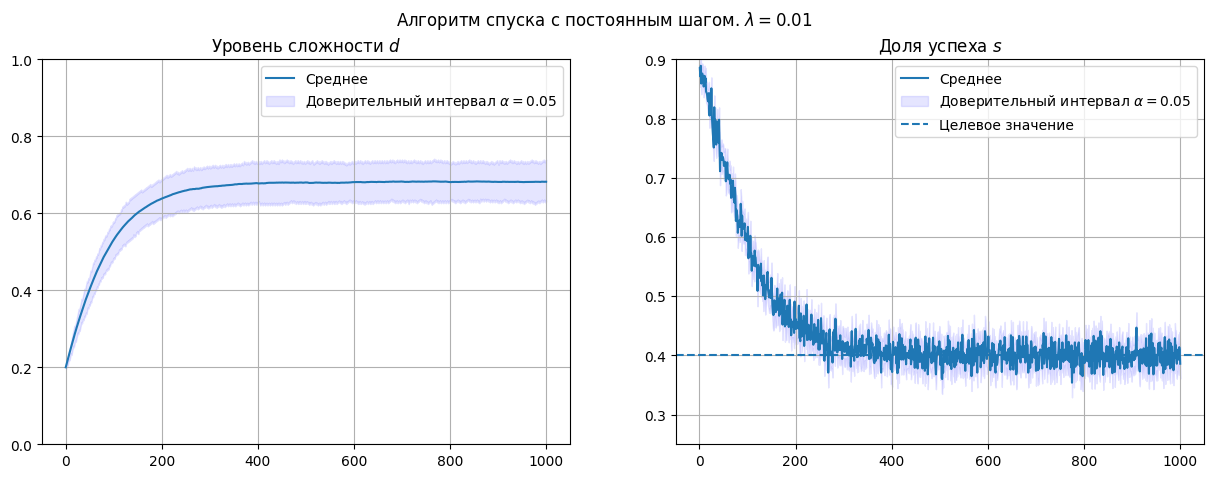

100%|██████████| 1000/1000 [00:01<00:00, 696.13it/s]


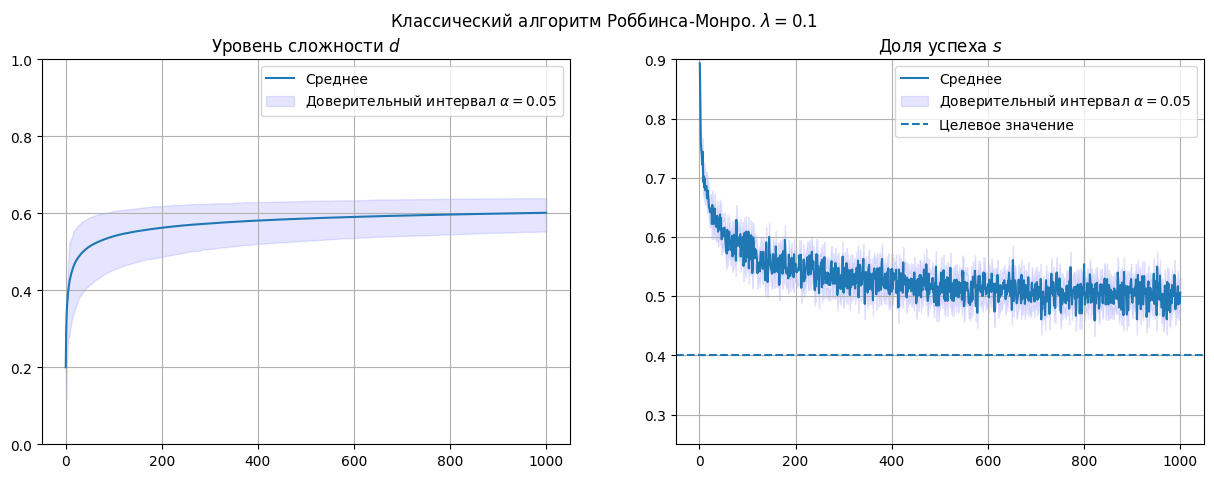

100%|██████████| 1000/1000 [00:01<00:00, 593.95it/s]


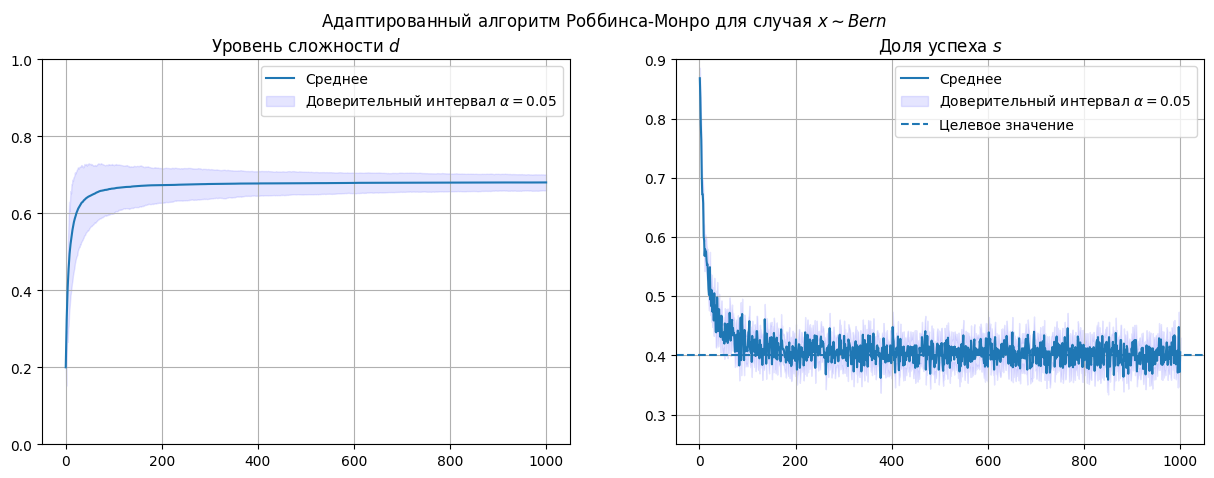

In [83]:
optimal_try_rate = 0.4
initial_difficulty = 0.2
slop = 5
rounds = 1000
tries = 1_000

titles = [
    r'Алгоритм спуска с постоянным шагом. $\lambda=0.01$',
    r'Классический алгоритм Роббинса-Монро. $\lambda=0.1$',
    r'Адаптированный алгоритм Роббинса-Монро для случая $x \sim Bern$'
]

update_rules = [
    ConstantUpdateRule(
            response_rate=0.01,
            optimal_try_rate=optimal_try_rate
    ),
    RobinsUpdateRule(
            response_rate=0.2,
            optimal_try_rate=optimal_try_rate
    ),
    AdaptedLogisticRule(
        start_point = initial_difficulty, 
        optimal_try_rate =optimal_try_rate,
        rounds=1001,
        slop=slop,
    )
]
experiment(
    update_rules=update_rules,
    titles = titles,
    optimal_try_rate=optimal_try_rate,
    initial_difficulty =initial_difficulty,
    rounds = rounds,
    tries = tries,
    response_function = ResponseFunction(elo(
            player_level =0.6,
            dispersion=0.2
    )),
    min_val =0.25, max_val=0.9
)

### Эксперимент 2

Задача оценить способность алгоритма к значительному изменению сложности

100%|██████████| 1000/1000 [00:01<00:00, 519.32it/s]


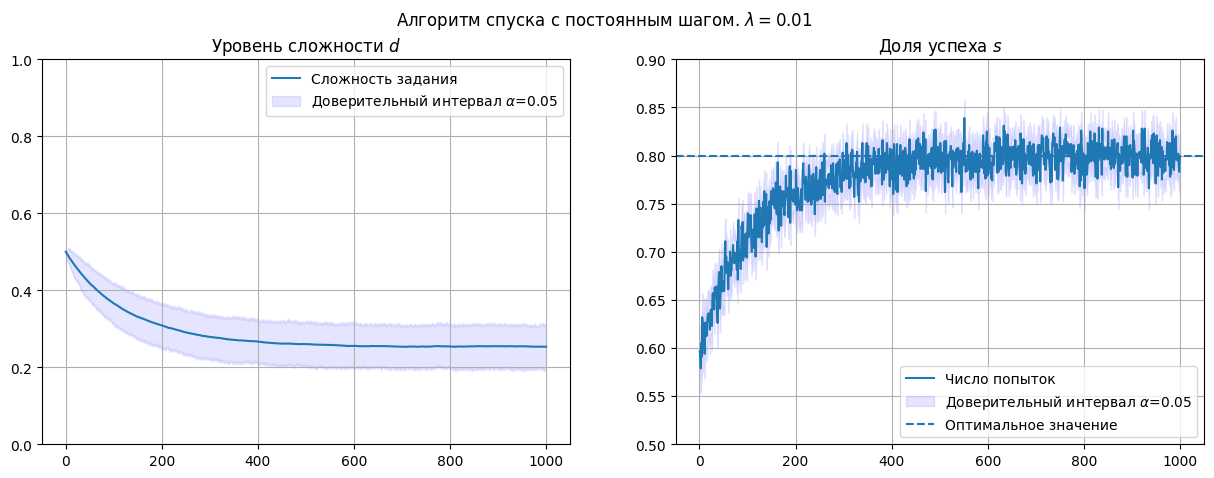

100%|██████████| 1000/1000 [00:02<00:00, 487.20it/s]


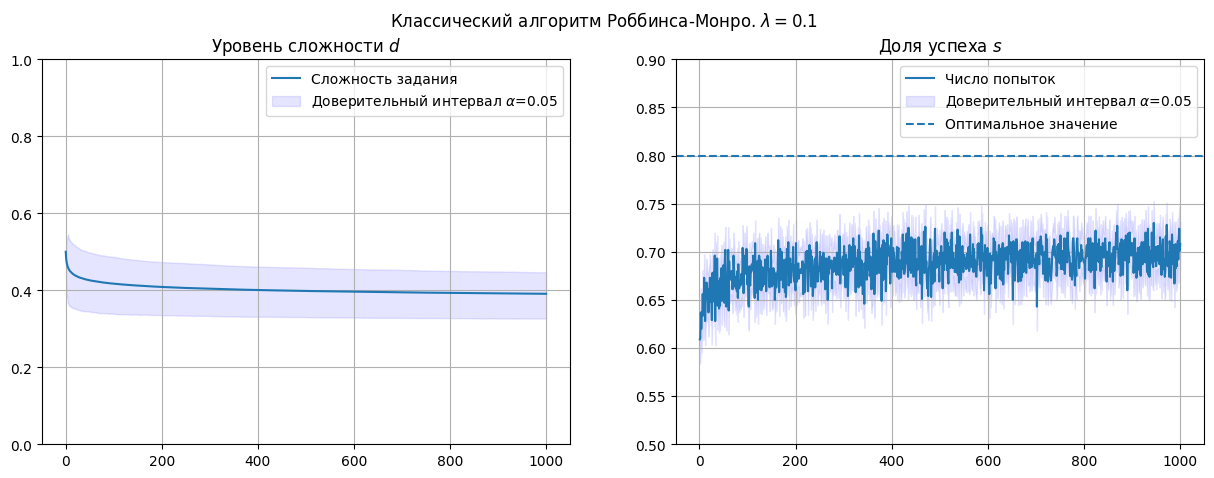

100%|██████████| 1000/1000 [00:01<00:00, 555.08it/s]


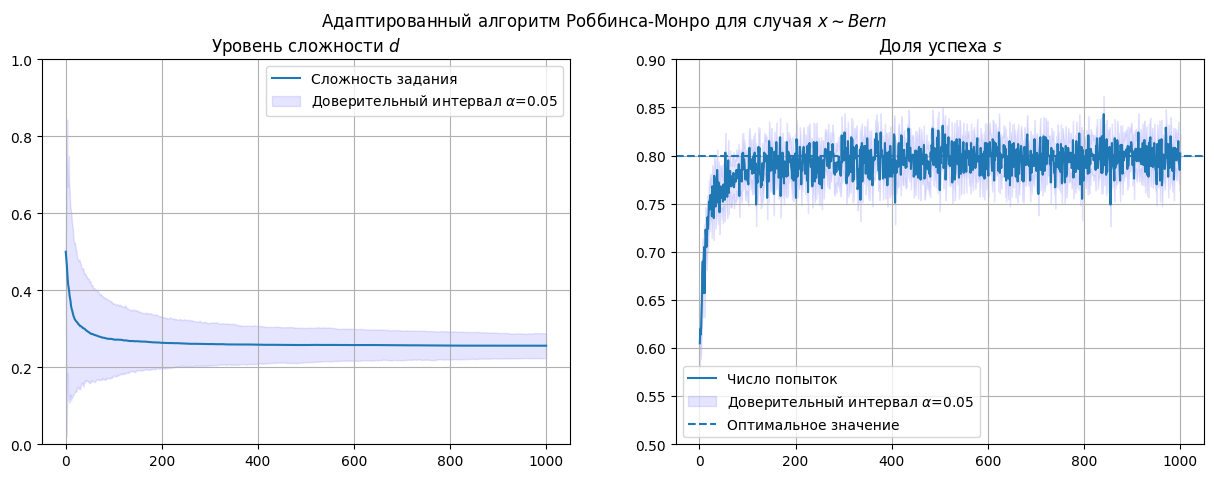

In [24]:
optimal_try_rate = 0.8
initial_difficulty = 0.5

titles = [
    r'Алгоритм спуска с постоянным шагом. $\lambda=0.01$',
    r'Классический алгоритм Роббинса-Монро. $\lambda=0.1$',
    r'Адаптированный алгоритм Роббинса-Монро для случая $x \sim Bern$'
]

update_rules = [
    ConstantUpdateRule(
        response_rate=0.01,
        optimal_try_rate=optimal_try_rate
    ),
    RobinsUpdateRule(
        response_rate=0.1,
        optimal_try_rate=optimal_try_rate
    ),
    AdaptedLogisticRule(
        start_point = initial_difficulty, 
        optimal_try_rate =optimal_try_rate,
        rounds=1001,
        slop=4
    )
]
experiment(
    update_rules=update_rules,
    titles = titles,
    optimal_try_rate=optimal_try_rate,
    initial_difficulty =initial_difficulty,
    rounds = 1000,
    tries = 1000,
    response_function = ResponseFunction(elo(
            player_level =0.6,
            dispersion=0.25
    )),
    min_val=0.5,
    max_val=0.9
)

### Эксперимент 3

Малые изменения коэффициента

In [ ]:
optimal_try_rate = 0.8
initial_difficulty = 0.5
rounds = 100
tries = 1000

titles = [
    r'Алгоритм спуска с постоянным шагом. $\lambda=0.01$',
    r'Классический алгоритм Роббинса-Монро. $\lambda=0.1$',
    r'Адаптированный алгоритм Роббинса-Монро для случая $x \sim Bern$'
]

update_rules = [
    ConstantUpdateRule(
        response_rate=0.01,
        optimal_try_rate=optimal_try_rate
    ),
    RobinsUpdateRule(
        response_rate=0.1,
        optimal_try_rate=optimal_try_rate
    ),
    AdaptedLogisticRule(
        start_point = initial_difficulty, 
        optimal_try_rate =optimal_try_rate,
        rounds=1001,
        slop=4
    )
]
experiment(
    update_rules=update_rules,
    titles = titles,
    optimal_try_rate=optimal_try_rate,
    initial_difficulty =initial_difficulty,
    rounds = rounds,
    tries = tries,
    response_function = ResponseFunction(elo(
        player_level =0.6,
        dispersion=0.25
    )),
    min_val=0.6,
    max_val=0.9
)

### Эксперимент 4

Использование метода Поляка для устранения высокочастотного шума

#### Постоянный шаг

In [72]:
initial_difficulty = 0.2
rounds=1000
tries=1_000
response_function = ResponseFunction(elo(
    player_level =0.6,
    dispersion=0.25
))


experiment_results_with_modifier = Test(
    initial_difficulty = initial_difficulty,
    rounds=rounds,
    tries=tries,
    response_function = response_function,
    update_rule=PolyakModifier(
        ConstantUpdateRule(
            response_rate=0.1,
            optimal_try_rate=optimal_try_rate
        ), 10
    ),
).perform().history


experiment_results_without_modifier = Test(
    initial_difficulty = initial_difficulty,
    rounds=rounds,
    tries=tries,
    response_function = response_function,
    update_rule=ConstantUpdateRule(
        response_rate=0.005,
        optimal_try_rate=optimal_try_rate
    )
).perform().history


  5%|▌         | 50/1000 [00:00<00:01, 487.26it/s]

100%|██████████| 1000/1000 [00:01<00:00, 539.93it/s]


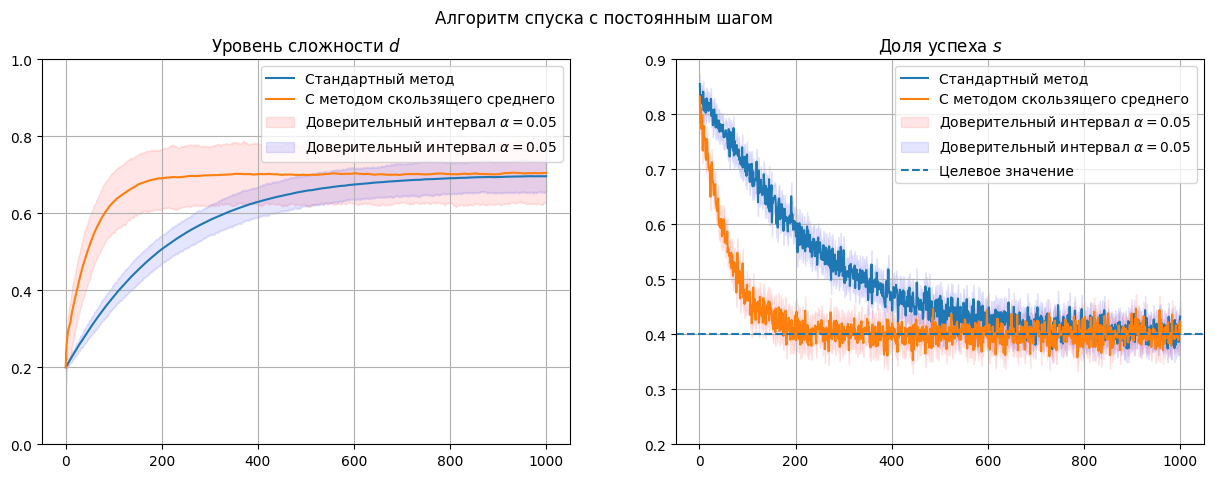

In [73]:
(
    Plotter('Алгоритм спуска с постоянным шагом',min_val = 0.2, max_val= 0.9)
        .plot_mean(experiment_results_without_modifier,label='Стандартный метод')
        .plot_mean(experiment_results_with_modifier, label='С методом скользящего среднего')

        .confidence_interval(experiment_results_with_modifier,color='r')
        .confidence_interval(experiment_results_without_modifier,color='b')
        .plot_hline(optimal_try_rate)
        # .confidence_interval(experiment_results)
        .show()
)

#### Адаптивный алгоритм

In [78]:
initial_difficulty = 0.2
rounds=1000
tries=1_000
response_function = ResponseFunction(elo(
    player_level =0.6,
    dispersion=0.25
))
slop=5


experiment_results_with_modifier = Test(
    initial_difficulty = initial_difficulty,
    rounds=rounds,
    tries=tries,
    response_function = response_function,
    update_rule=PolyakModifier(
        AdaptedLogisticRule(
            start_point = initial_difficulty, 
            optimal_try_rate =optimal_try_rate,
            rounds=rounds,
            slop=slop
        ),50
    )
).perform().history


experiment_results_without_modifier = Test(
    initial_difficulty = initial_difficulty,
    rounds=rounds,
    tries=tries,
    response_function = response_function,
    update_rule=AdaptedLogisticRule(
        start_point = initial_difficulty, 
        optimal_try_rate =optimal_try_rate,
        rounds=rounds,
        slop=slop
    )
).perform().history


100%|██████████| 1000/1000 [00:01<00:00, 504.35it/s]


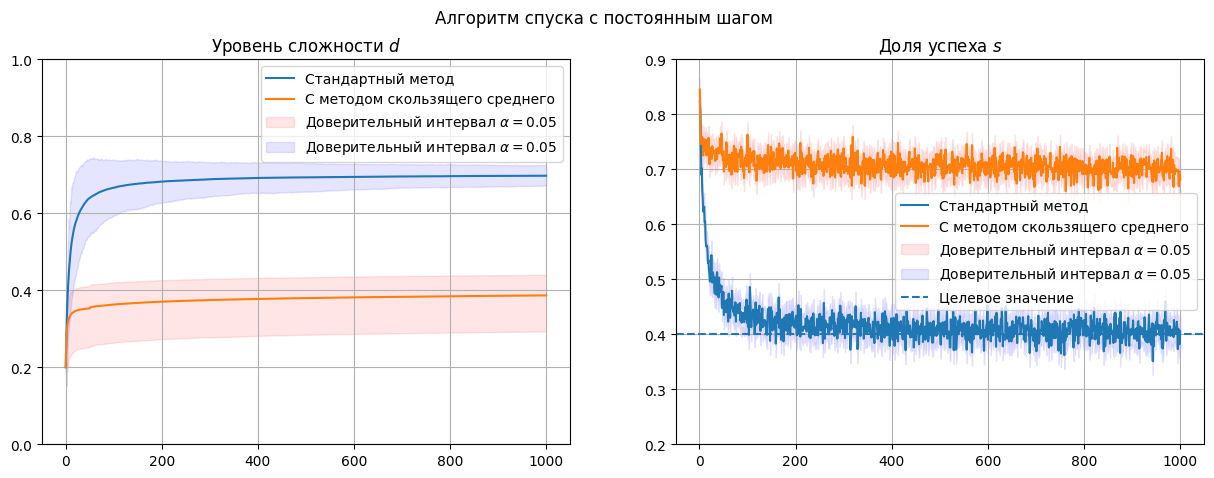

In [79]:
(
    Plotter('Алгоритм спуска с постоянным шагом',min_val = 0.2, max_val= 0.9)
        .plot_mean(experiment_results_without_modifier,label='Стандартный метод')
        .plot_mean(experiment_results_with_modifier, label='С методом скользящего среднего')

        .confidence_interval(experiment_results_with_modifier,color='r')
        .confidence_interval(experiment_results_without_modifier,color='b')
        .plot_hline(optimal_try_rate)
        # .confidence_interval(experiment_results)
        .show()
)

100%|██████████| 1000/1000 [00:02<00:00, 457.43it/s]


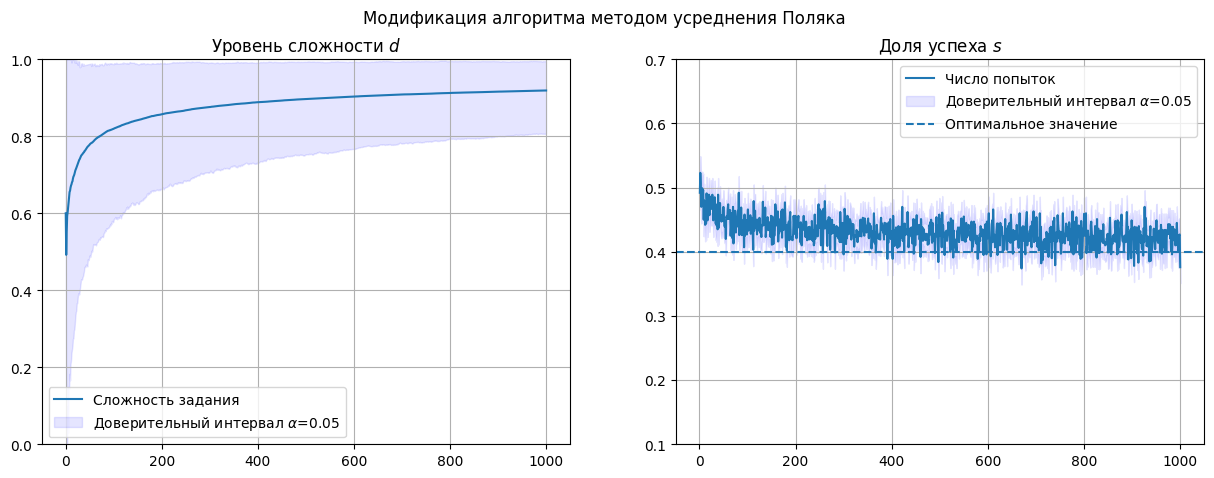

In [28]:

initial_difficulty = 0.6
optimal_try_rate = 0.4

titles = [
    'Модификация алгоритма методом усреднения Поляка'
]

update_rules = [
    RobinsUpdateRule(
        response_rate=1.5,
        optimal_try_rate=optimal_try_rate
    )
    # PolyakModifier(AdaptedLogisticRule(
    #     start_point = initial_difficulty, 
    #     optimal_try_rate =optimal_try_rate,
    #     rounds=1001,
    # ))
]
experiment(
    update_rules=update_rules,
    titles = titles,
    optimal_try_rate=optimal_try_rate,
    initial_difficulty =initial_difficulty,
    rounds = 1000,
    tries = 1000,
    response_function = ResponseFunction(elo(
            player_level =0.6,
            dispersion=1
    )),
    min_val=0.1,
    max_val=0.7
)

100%|██████████| 10000/10000 [02:12<00:00, 75.60it/s]


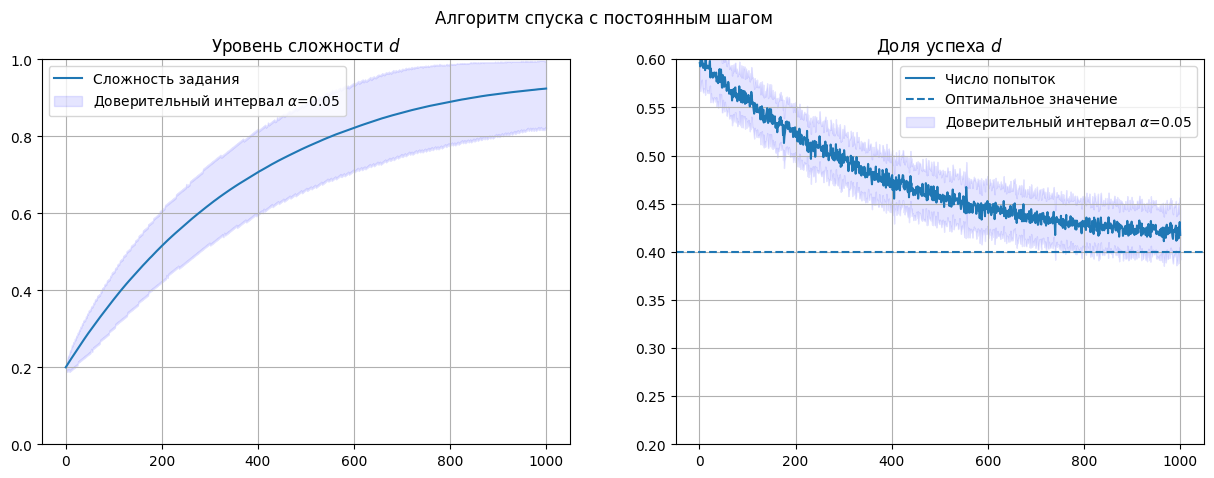

100%|██████████| 10000/10000 [00:41<00:00, 239.02it/s]


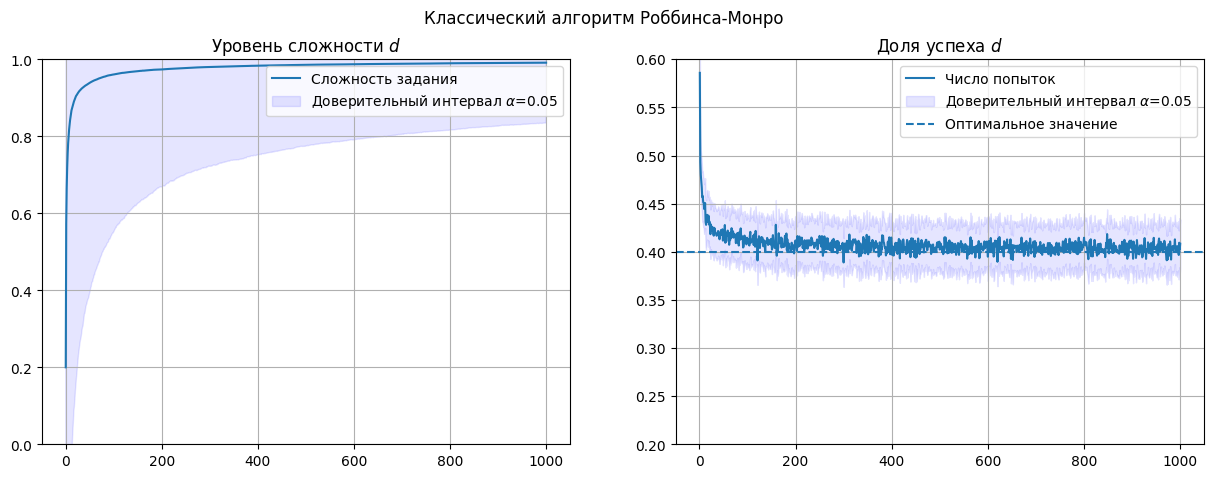

In [773]:
experiment_results = Test(
    initial_difficulty = initial_difficulty,
    rounds=1000,
    tries=10_000,
    response_function = response_function,
    update_rule=ProjectedUpdateRule(
        response_rate=0.01,
        optimal_try_rate=optimal_try_rate
    ),
).perform().history

(
    Plotter('Алгоритм спуска с постоянным шагом',)
    .plot_mean(experiment_results)
    .plot_hline(optimal_try_rate)
    .confidence_interval(experiment_results)
    .show()
)


In [ ]:
experiment_results = Test(
    initial_difficulty = initial_difficulty,
    rounds=1000,
    tries=10_000,
    response_function = response_function,
    update_rule=RobinsUpdateRule(
        response_rate=2,
        optimal_try_rate=optimal_try_rate
    ),
).perform().history
(
    Plotter('Классический алгоритм Роббинса-Монро',)
    .plot_mean(experiment_results)
    .confidence_interval(experiment_results)
    .plot_hline(optimal_try_rate)
    .show()
)

100%|██████████| 10000/10000 [00:29<00:00, 340.98it/s]


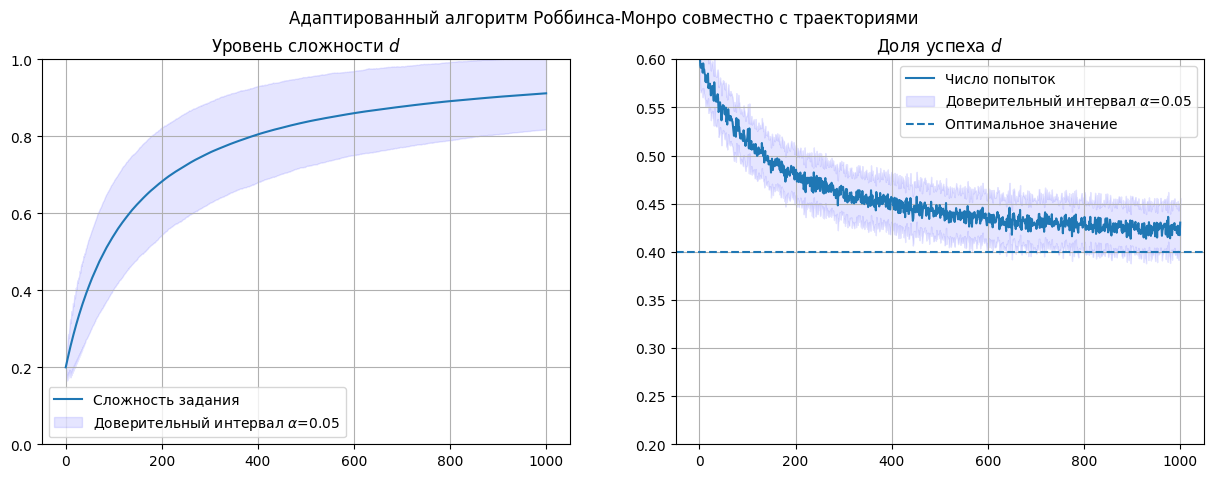

In [769]:
experiment_results = Test(
    initial_difficulty = initial_difficulty,
    rounds=1000,
    tries=10_000,
    response_function = response_function,
    update_rule=AdaptedLogisticRule(
        start_point = initial_difficulty, optimal_try_rate =optimal_try_rate,rounds=1001,
    ),
).perform().history
(
    Plotter('Адаптированный алгоритм Роббинса-Монро cовместно с траекториями',)
    .plot_mean(experiment_results)
    #.plot_trajectories(experiment_results,10)
    .confidence_interval(experiment_results)
    .plot_hline(optimal_try_rate)
    .show()
)


In [237]:
Test(
    initial_difficulty = 0.5,
    rounds=100,
    tries=10,
    title='Алгоритм Роббинса-Монро',
    response_function = ResponseFunction(elo(
        player_level =0.5,dispersion=0.01
    )),
    update_rule=PolyakUpdateRule(
        response_rate=0.2,
        optimal_try_rate=0.3
    ),
).perform().plot()

TypeError: descriptor '__init__' requires a 'super' object but received a 'float'